In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib 
import matplotlib.pyplot as plt
import seaborn as sns
import scanpy as sc
from sklearn import metrics
import tabulate
import itertools
import umap
from importlib import reload
from scipy import stats
import matplotlib.image as mpimg
import goatools
from goatools.anno.gaf_reader import GafReader
import Bio.UniProt.GOA as GOA
import gget

# locals
import utils as ut
reload(ut)

2022-11-15 13:57:43.535495: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-11-15 13:57:43.672625: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/slurm/lib64:
2022-11-15 13:57:43.672648: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-11-15 13:57:43.698684: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2022-11-15 13:57:44.8238

<module 'utils' from '/home/cstansbu/git_repositories/spatial_transcriptomics/clustering/utils.py'>

In [2]:
choose = 50 # number of genes to consider

# load gene lists 
pandPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/panglaodb/pandb.tsv.gz"        
pandf = ut.read_panglaodb(pandPath)

controlList = [
    'Adipocytes',
    'B cells', 
    'Dendritic cells',
    'Macrophages',
    'Monocytes', 
    'NK cells',
    'T cells', 
]

allMarkers = pandf[pandf['cell type'].isin(controlList)]

mfList = []
for ctype in controlList:
    cf = allMarkers[allMarkers['cell type'] == ctype]
    cf = cf.sort_values(by='ubiquitousness index',
                        ascending=True)
    mfList.append(cf[['cell type', 'gene']].head(choose))


markerGenes = pd.concat(mfList, ignore_index=True)
print(pd.DataFrame(markerGenes['cell type'].value_counts()))
print()

                 cell type
Adipocytes              50
B cells                 50
Dendritic cells         50
Macrophages             50
Monocytes               50
NK cells                50
T cells                 50



In [3]:
# load cluster assignments
cdf = pd.read_csv("clusterAssignments.csv")
cid = {}

for key in cdf['key'].unique():
    t = cdf[cdf['key'] == key]
    cid[key] = t
    
print('done')

done


# Load saved data

In [4]:
dirPath = "/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/"

adata = {}

for f in os.listdir(dirPath):
    
    if f.endswith('.h5ad'):
        key = f.split(".")[0]
        fullPath = f"{dirPath}{f}"
        data = sc.read(fullPath)
        adata[key] = data
    
print("done")

done


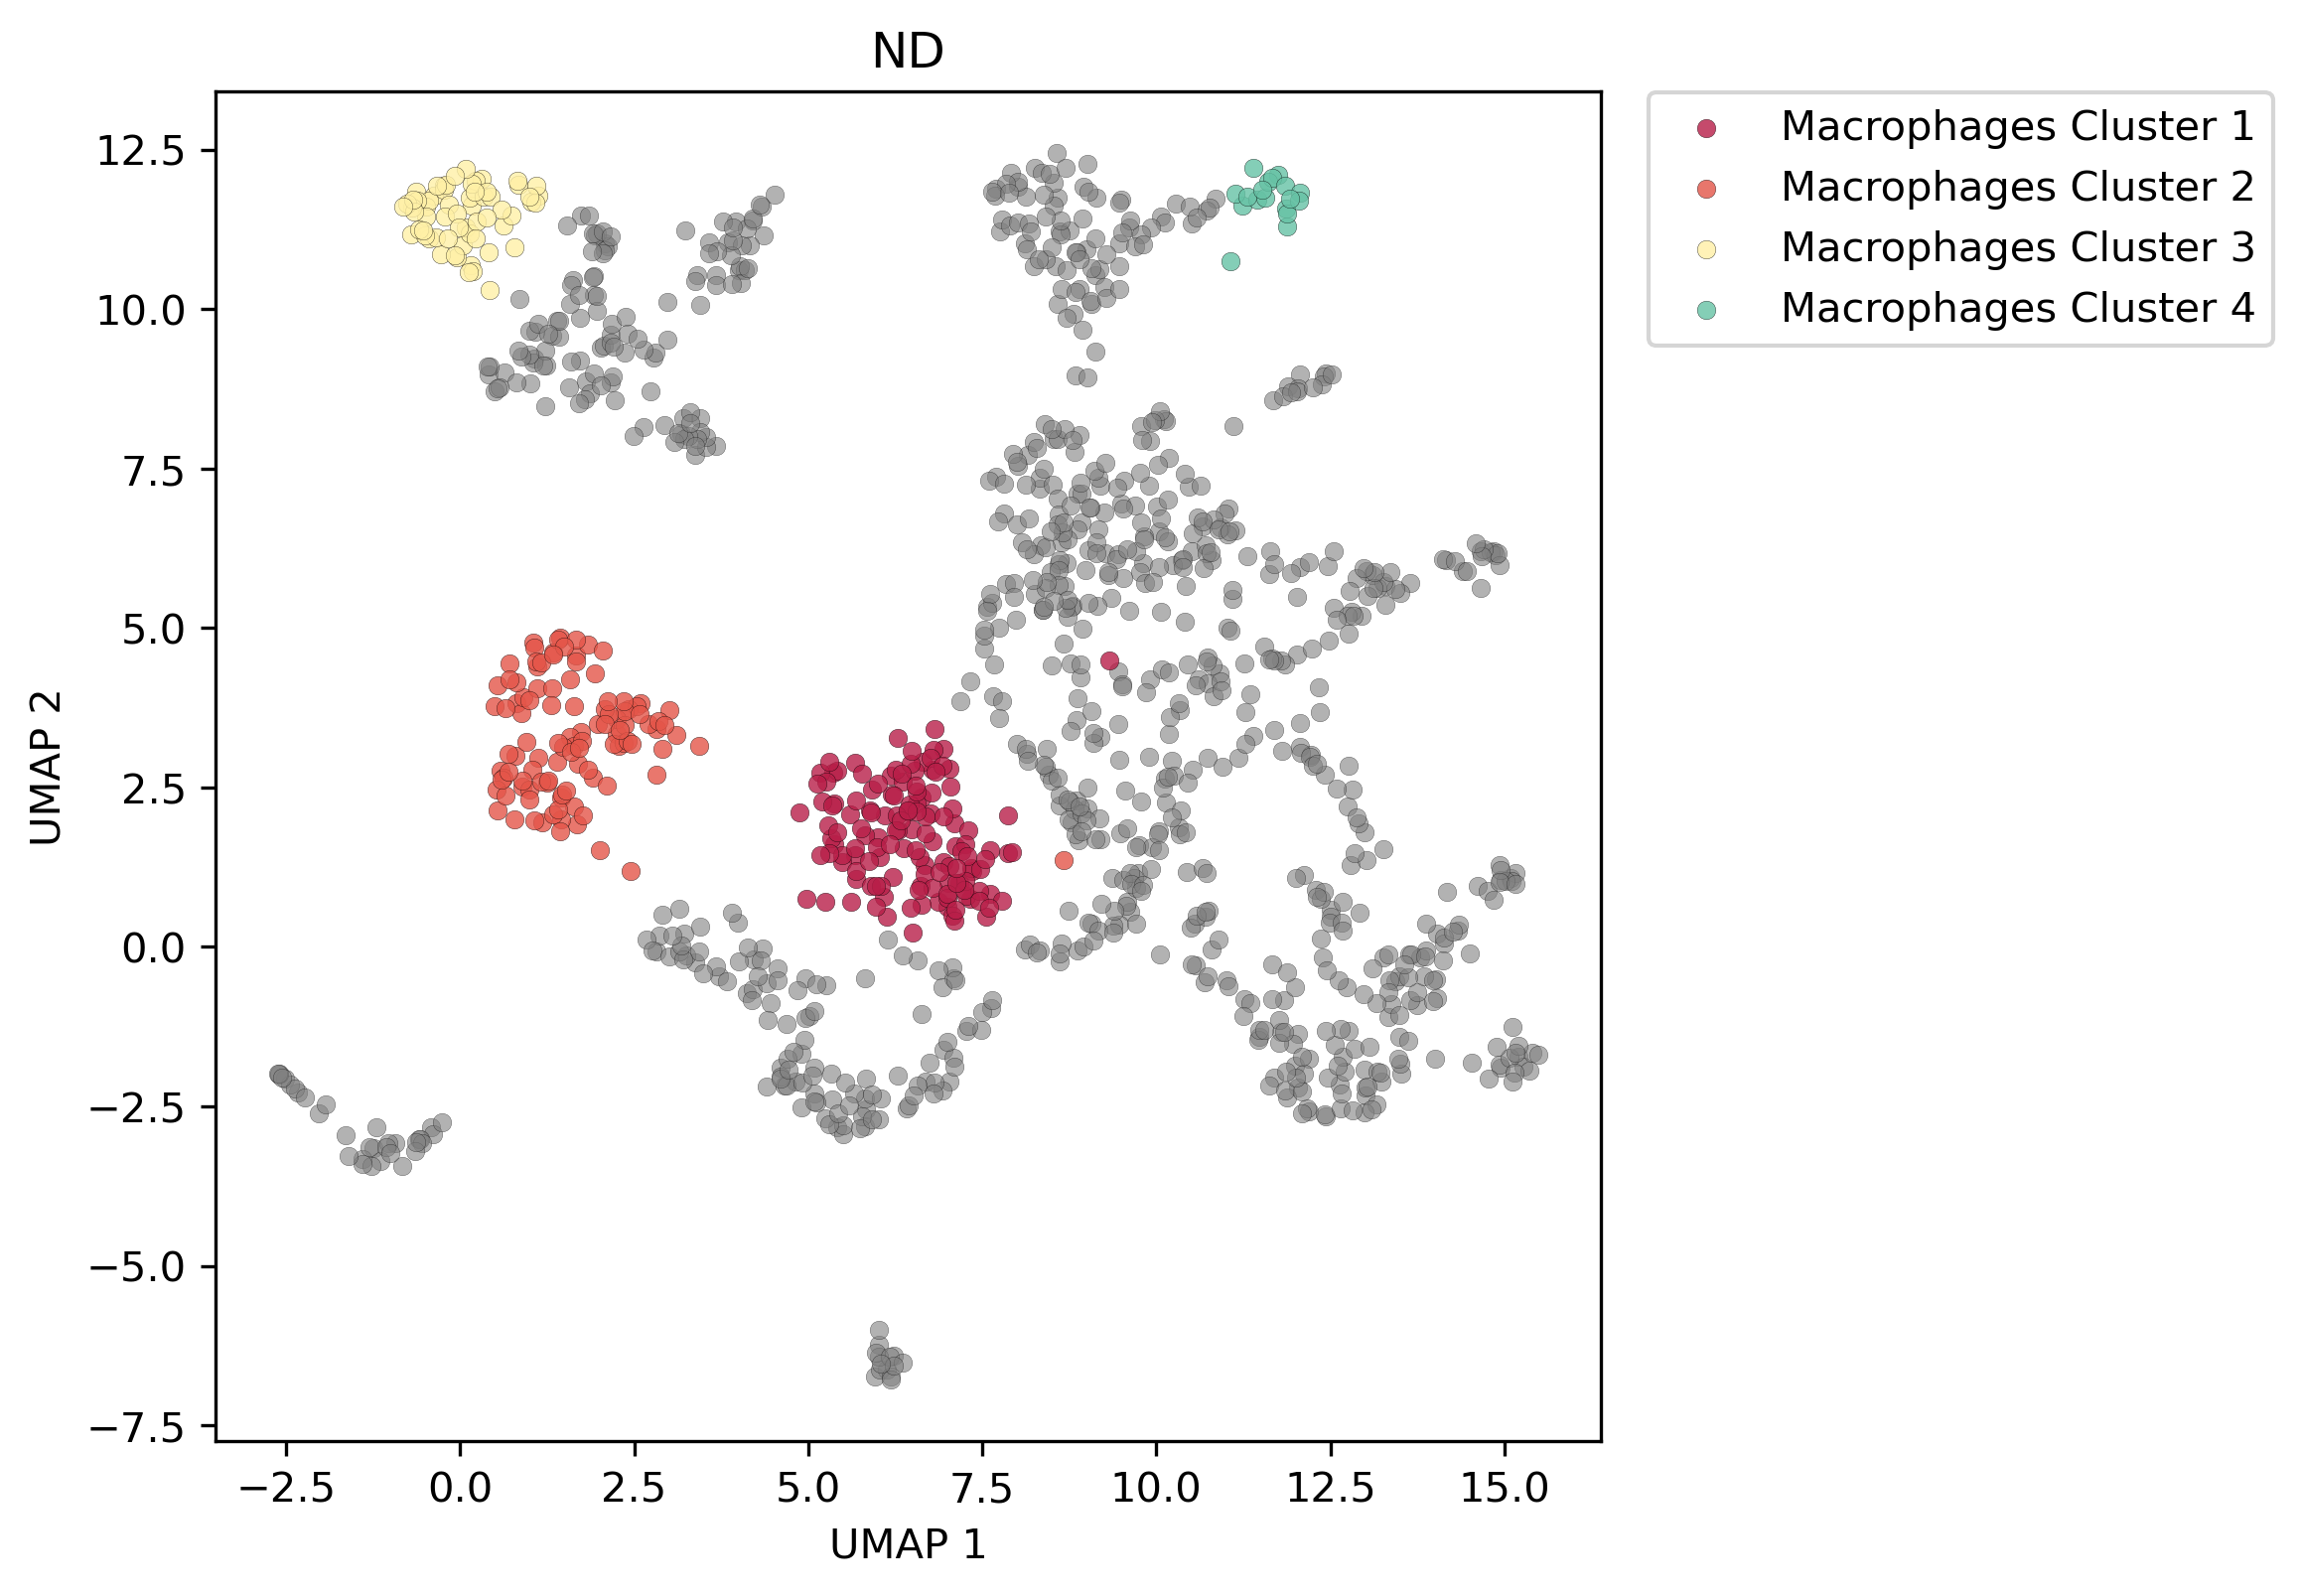

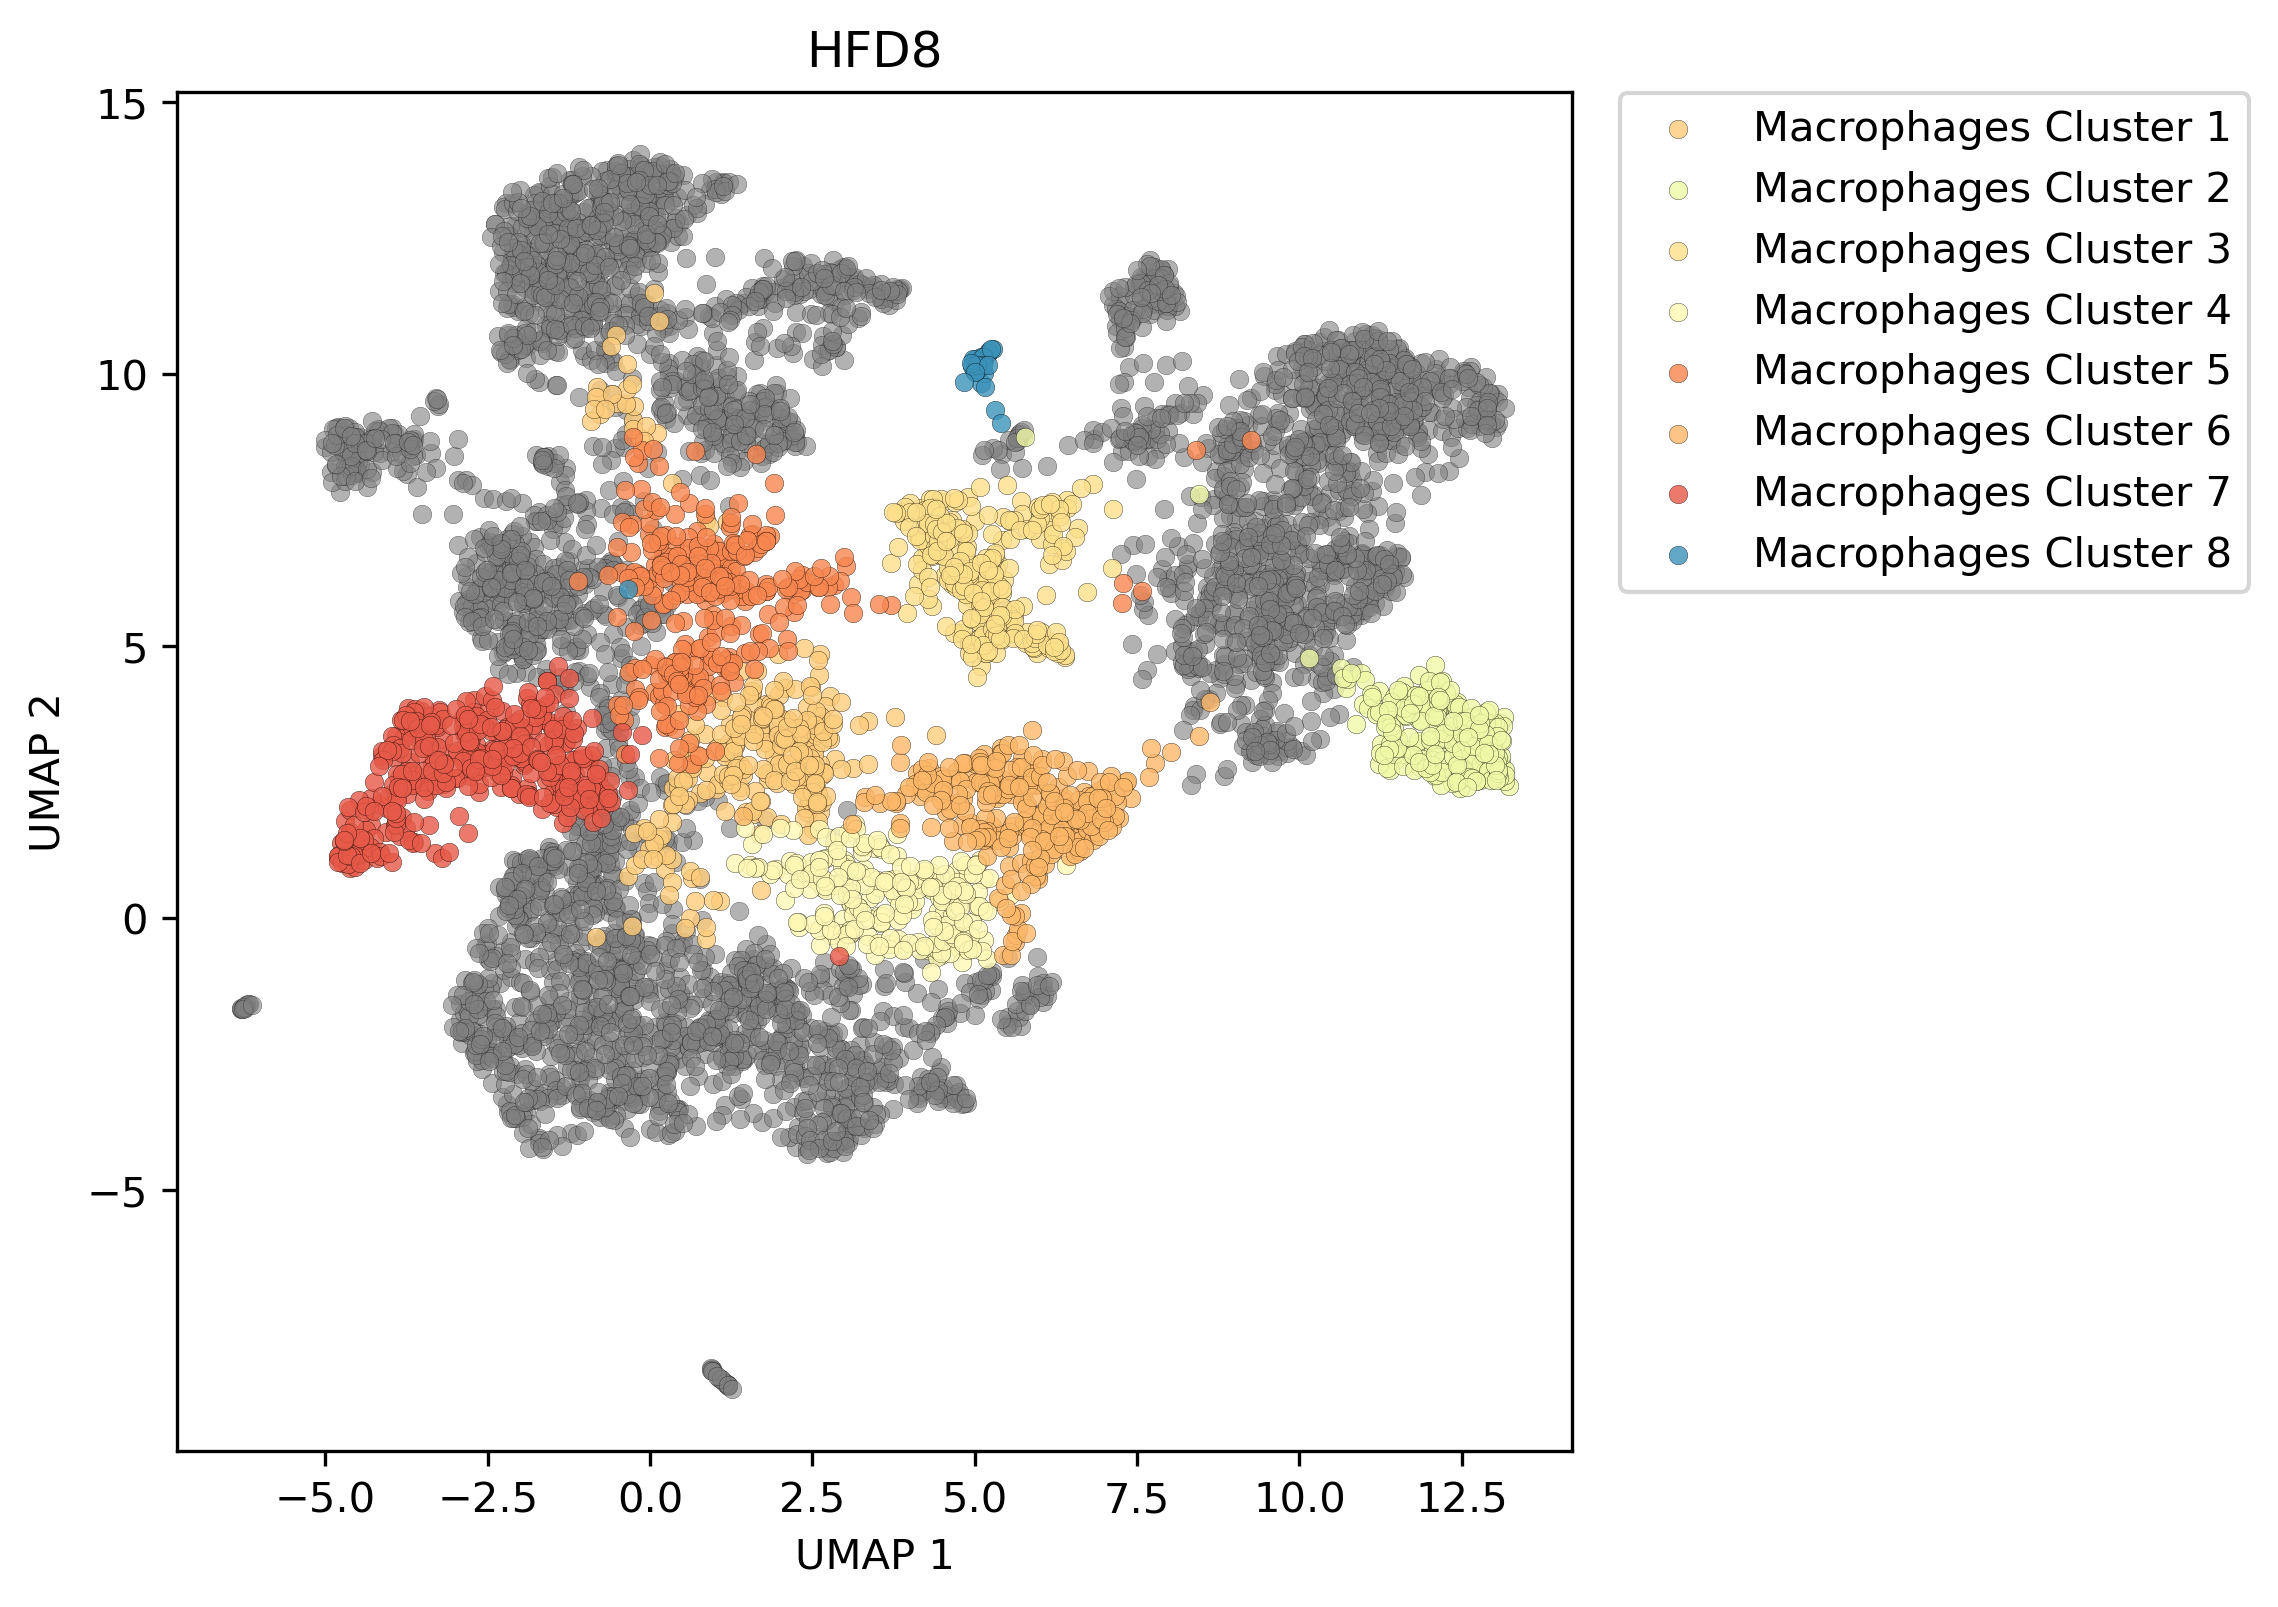

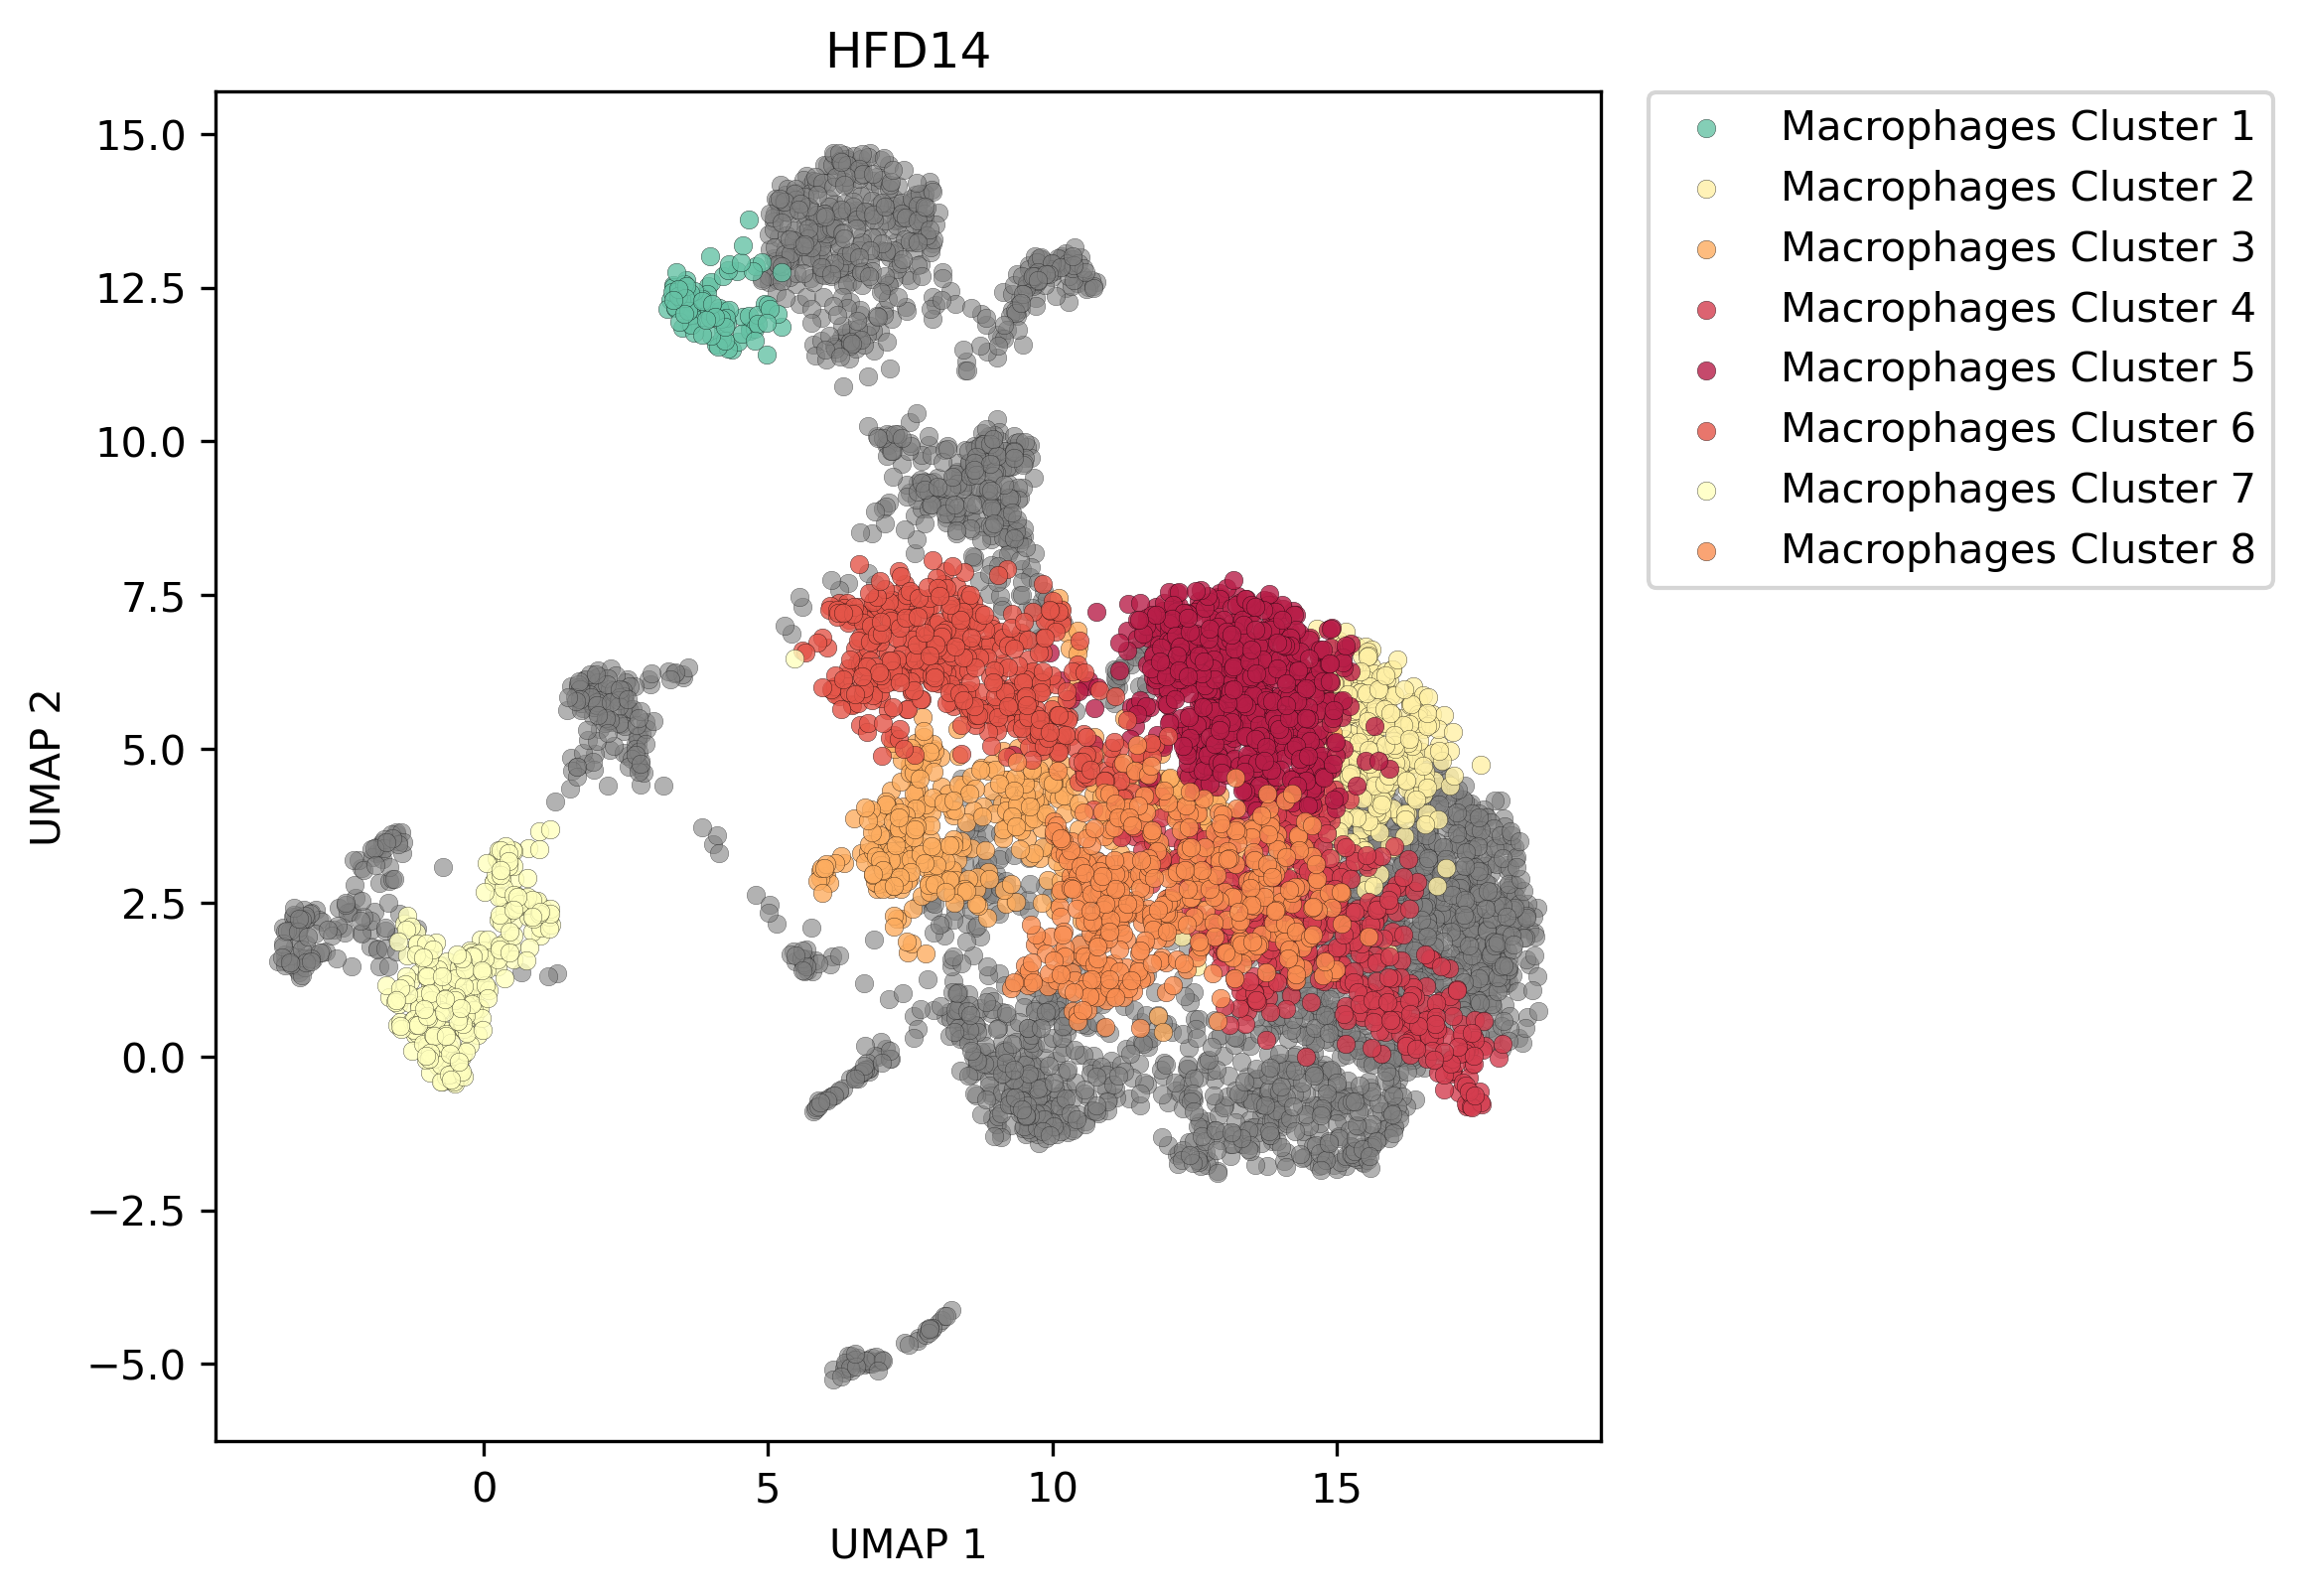

In [5]:
cellType = 'Macrophages'

plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 6, 6
keys = ['ND', 'HFD8', 'HFD14']

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1    
    # get number of clusterss
    k = data.obs[runKey].nunique() + 1
    colorlist = ut.ncolor(k, cmap='Spectral')
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    cellTypeIds = cellTypes[cellTypes['cellType'] == cellType]['clusterId'].to_numpy()
    
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    """
    PLOT background
    """
    cellInd = clusterIds.isin(cellTypeIds)

    plt.scatter(embedding[~cellInd, 0],
                embedding[~cellInd, 1],
                c='grey',
                edgecolor="k",
                linewidth=0.1,
                s=20,
                alpha=0.6)
    
    for i, ctid in enumerate(cellTypeIds):
        cellInd = (clusterIds == ctid)
        
        label = f"{cellType} Cluster {i+1}"
        
        plt.scatter(embedding[cellInd, 0],
                    embedding[cellInd, 1],
                    c=colorlist[ctid],
                    edgecolor="k",
                    linewidth=0.1,
                    s=20,
                    alpha=0.8,
                    label=label)

    plt.title(key)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")
    plt.legend(bbox_to_anchor=(1.5, 1.015))
    plt.show()
    

done


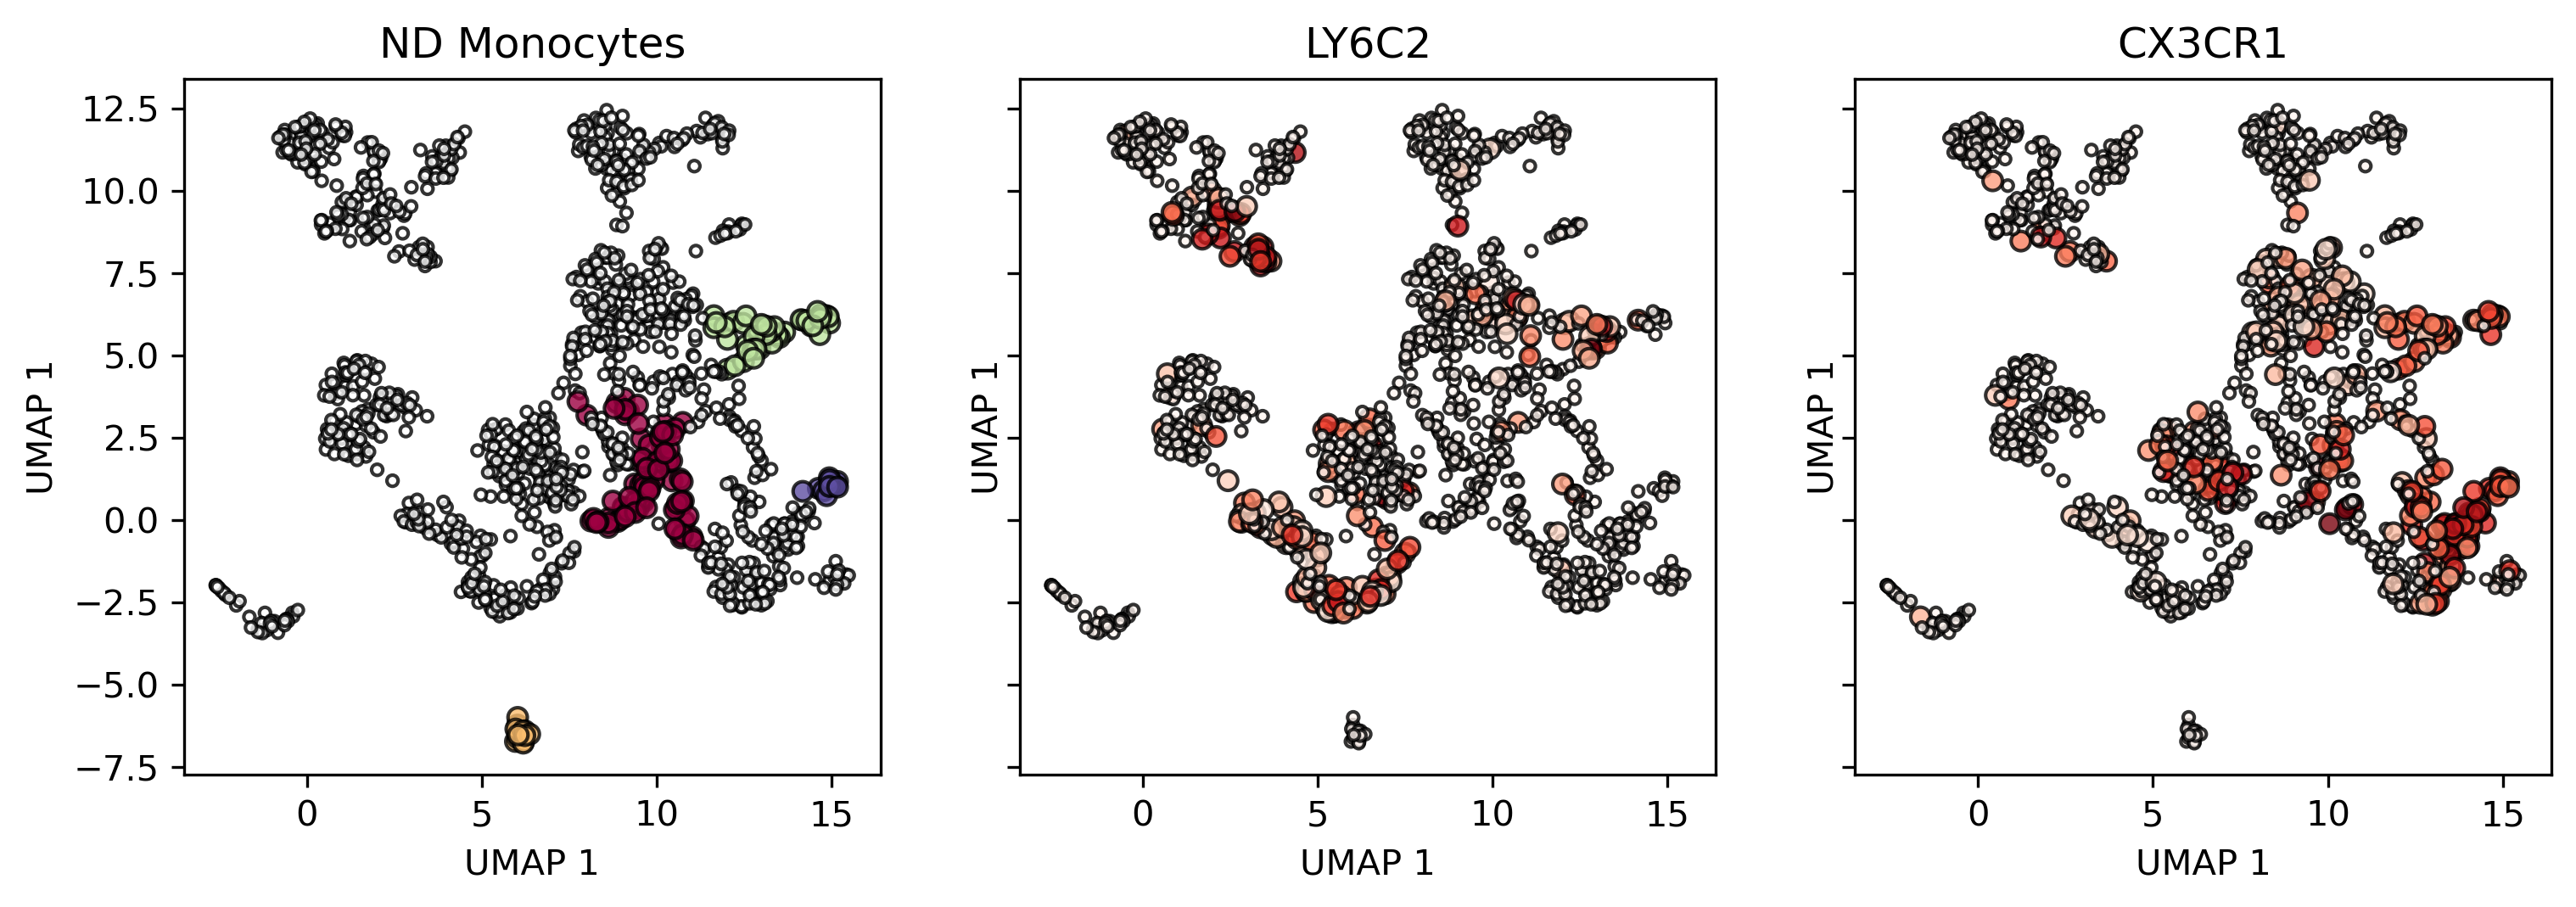

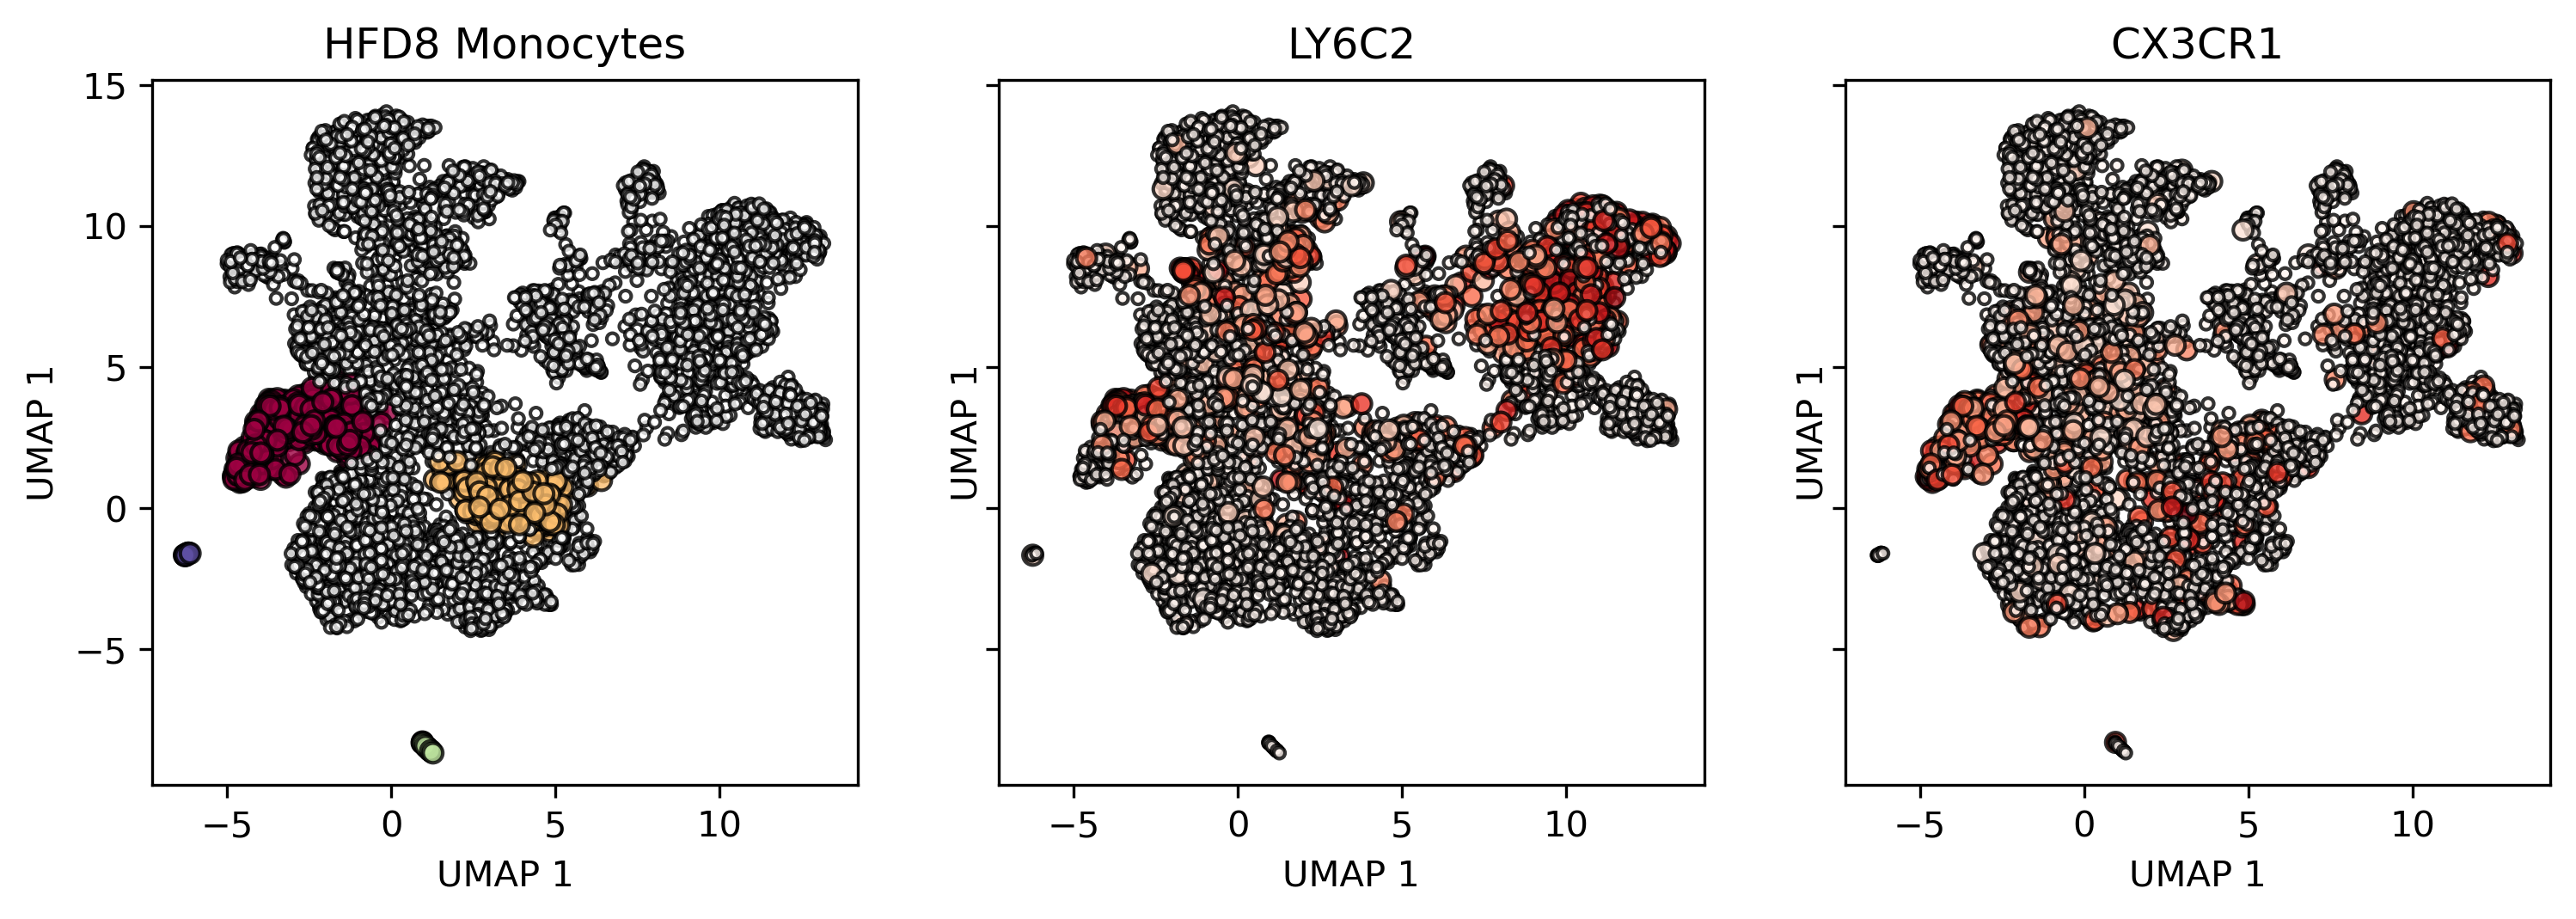

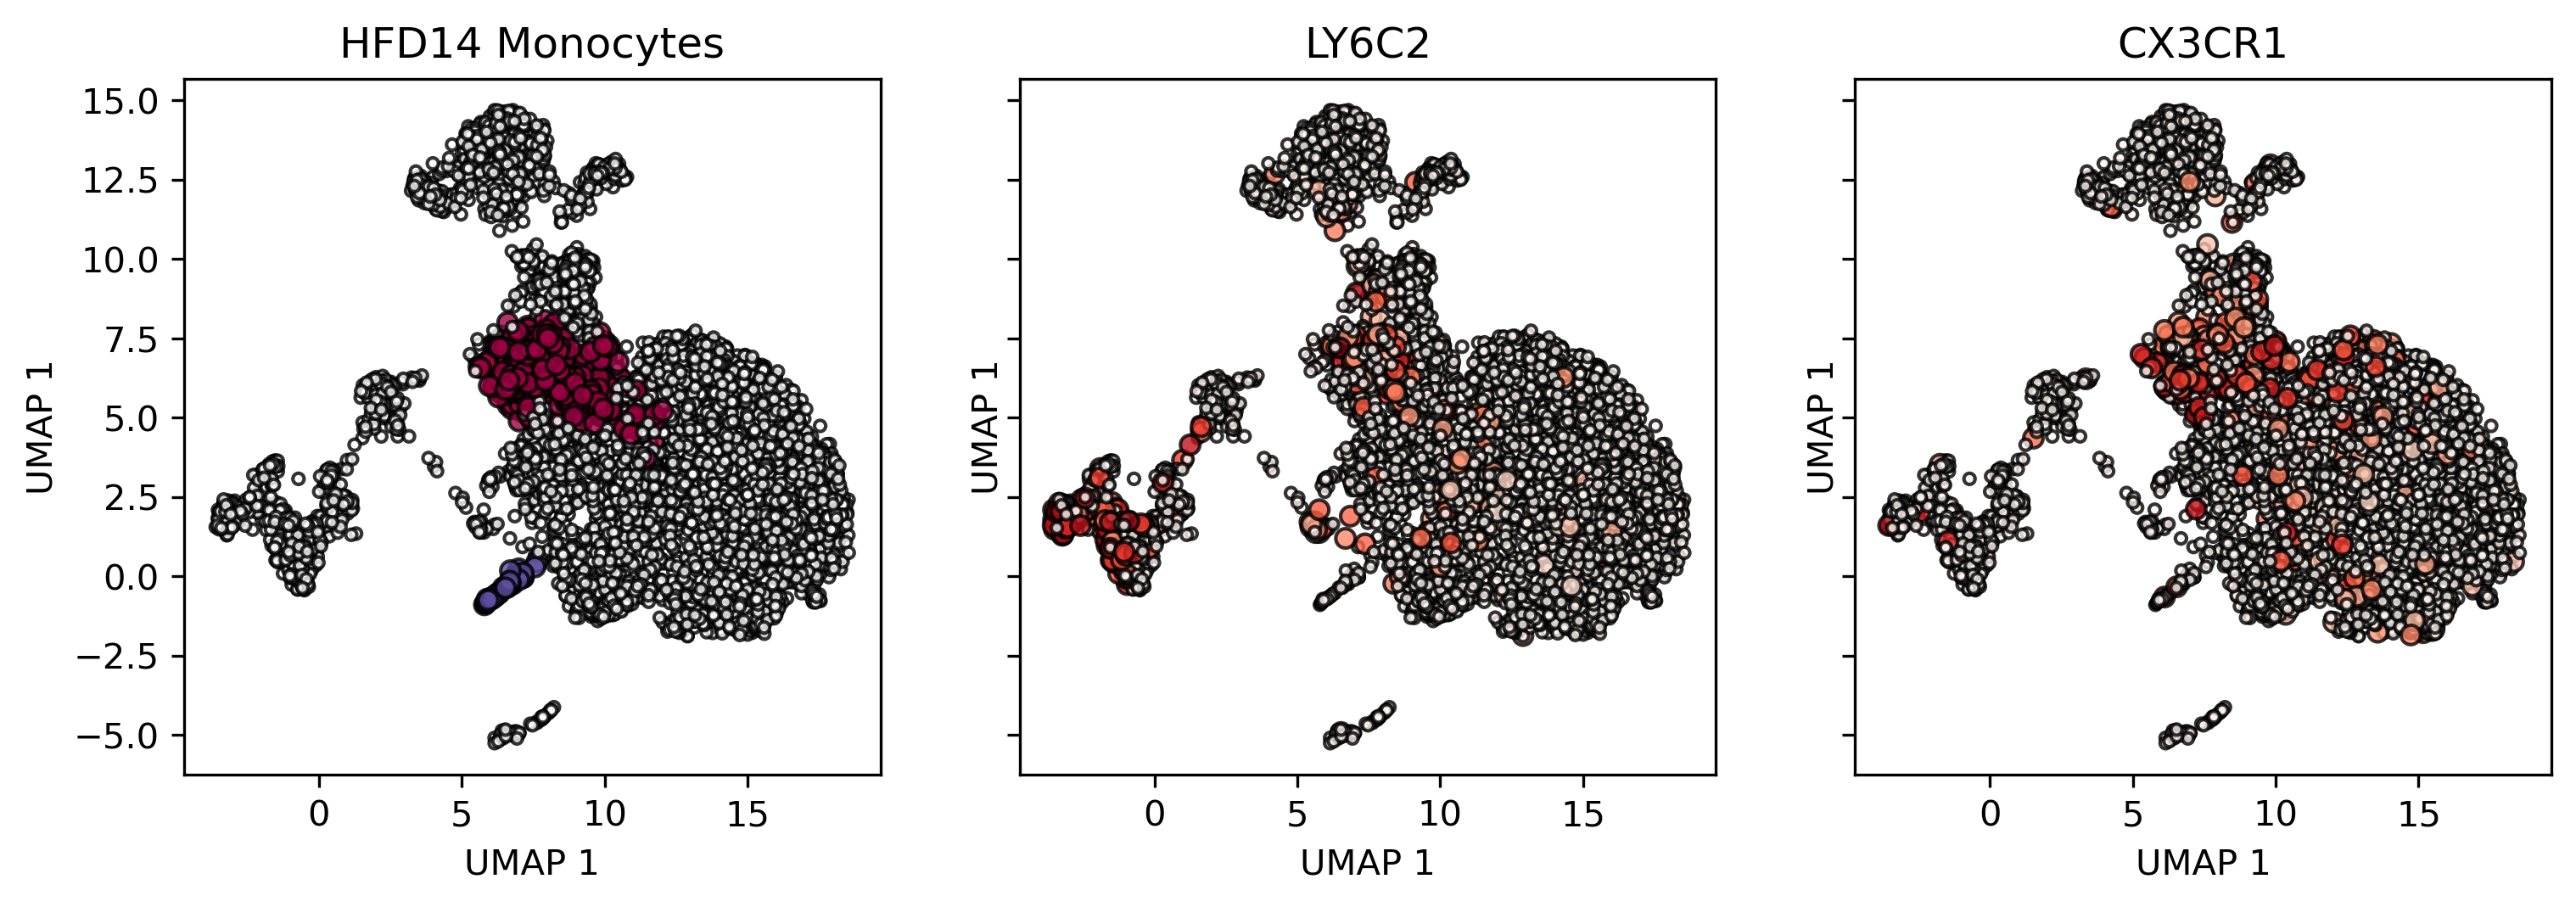

In [6]:
ctype = 'Monocytes'
runKey = "nn15_pca30_r0.75"
genes = ["Ly6c2", 'cx3cr1']
genes = [x.upper() for x in genes]
pltSize = 4


keys = ['ND', 'HFD8', 'HFD14']

res = []

for key in keys:
    data = adata[key]
    
    # get the run key
    allKeys = list(data.obs.keys() )
    allKeys.remove('n_genes')
    runKey = allKeys[0]
    
    clusterIds = data.obs[runKey].astype(int) + 1  # note that these are zero-indexed!
    df = data.to_df()
    
    # get all clusters for the cell type
    cellTypes = cid[key]
    
    # get 2d coordinates
    embedding = data.obsm['X_umap']
    
    cellTypeIds = cellTypes[cellTypes['cellType'] == ctype]['clusterId'].to_numpy()
        
    # set up th plot
    nPlots = len(genes) + 1

    plt.rcParams['figure.figsize'] = nPlots*pltSize, pltSize

    fig, axs = plt.subplots(1, nPlots, sharey=True, subplot_kw=dict(box_aspect=1))
    axs = axs.ravel()
    
    c = ['w'] * len(df)
    s = [10] * len(df)
    y_true = [0] * len(df)
    
    colorlist = ut.ncolor(len(cellTypeIds), cmap='Spectral')
    
    for i, ctid in enumerate(cellTypeIds):
        mask = (clusterIds == ctid)
        c = np.where(mask, colorlist[i], c)
        s = np.where(mask, 30, s)
        y_true = np.where(mask, 1, y_true)

    axs[0].scatter(embedding[: , 0], 
                   embedding[:, 1], 
                   c=c,
                   edgecolor="k",
                   s=s,
                   alpha=0.8)

    axs[0].set_title(f"{key} {ctype}")
    axs[0].set_xlabel("UMAP 1")
    axs[0].set_ylabel("UMAP 1")
        
    # plot the expression of each validation gene
    for i, g in enumerate(genes):
        plotNum = i + 1
        
        mask = df[g] > 0
        c = np.where(mask, "r", "w")
        s = np.where(mask, 30, 10)
        y_pred = np.where(mask, 1, 0)

        axs[plotNum].scatter(embedding[: , 0] , 
                             embedding[:, 1] , 
                             c=df[g],
                             cmap='Reds',
                             edgecolor="k",
                             s=s,
                             alpha=0.8)

        axs[plotNum].set_title(g)
        axs[plotNum].set_xlabel("UMAP 1")
        axs[plotNum].set_ylabel("UMAP 1")
        
        
        """Compute jaccard sim with the label """

        row = {
            'Key' : key,
            'cellType' : ctype,
            'Gene' : g,
            'jaccrd' : metrics.jaccard_score(y_true, y_pred),
            'accuracy' : metrics.accuracy_score(y_true, y_pred),
            'precision' : metrics.precision_score(y_true, y_pred),
        }

        res.append(row)
            
            
res = pd.DataFrame(res)
print('done')

Text(0.5, 1.0, 'Monocytes')

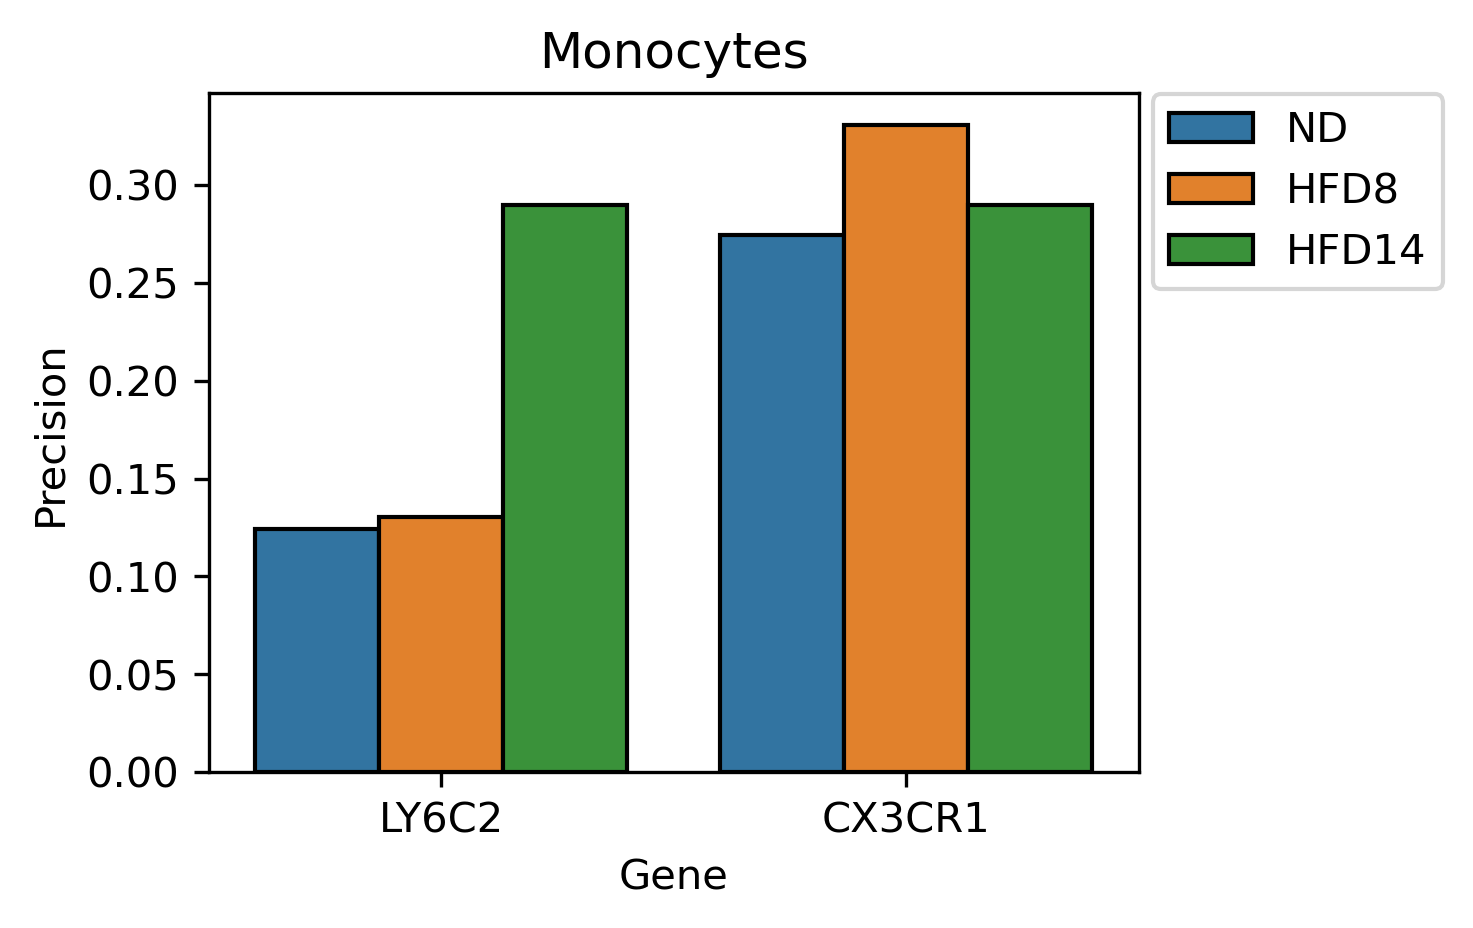

In [7]:
plt.rcParams['figure.dpi'] = 300
plt.rcParams['figure.figsize'] = 4, 3

sns.barplot(data=res,
            x='Gene',
            y='precision',
            edgecolor='k',
            hue='Key')

plt.legend(loc='upper right', bbox_to_anchor=(1.35, 1.028))
plt.xlabel('Gene')
plt.ylabel('Precision')
plt.title(ctype)

In [8]:
# break

# GO Enrichment Analysis

In [ ]:
# cellType = 'Monocytes'
cellType = 'Monocytes'
keys = ['ND', 'HFD8', 'HFD14']
topNgenes = 300

resList = {}

output = f"/nfs/turbo/umms-indikar/shared/projects/spatial_transcriptomics/data/scanpy/{cellType}.xlsx"
with pd.ExcelWriter(output) as writer:  
    for key in keys:
        print(f"working {key}")
        data = adata[key]
        df = data.to_df()
        result = data.uns['rank_genes_groups']
        keys = data.uns['rank_genes_groups'].keys()
        groups = result['names'].dtype.names

        clusterIds = data.obs[runKey].astype(int)
        cellTypes = cid[key]

        # get all clusters for the cell type
        cellTypeIds = cellTypes[cellTypes['cellType'] == cellType]['clusterId'].to_numpy()

        for ctid in cellTypeIds:
            genes = list(result['names'][str(ctid-1)])
            
            genes = genes[:topNgenes] # need to filter the top n genes
            
            gf = pd.Series(genes, name=f'top_{topNgenes}_genes') 
            sheetName = f"{key}_c_{ctid}_genes"
            gf.to_excel(writer, sheet_name=sheetName, index=False)
            
            sheetName = f"{key}_c_{ctid}_kegg"
            kegg = gget.enrichr(genes, database="KEGG_2019_Mouse")
            kegg.to_excel(writer, sheet_name=sheetName, index=False)
            
            sheetName = f"{key}_c_{ctid}_wiki"
            wiki = gget.enrichr(genes, database="WikiPathways_2019_Mouse")
            wiki.to_excel(writer, sheet_name=sheetName, index=False)
            
            sheetName = f"{key}_c_{ctid}_GO"
            onto = gget.enrichr(genes, database="ontology")
            onto.to_excel(writer, sheet_name=sheetName, index=False)
        
    
print("done")

Tue Nov 15 13:57:57 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.


working ND


Tue Nov 15 13:57:58 2022 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Tue Nov 15 13:57:58 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov 15 13:57:59 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov 15 13:58:00 2022 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Tue Nov 15 13:58:00 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov 15 13:58:02 2022 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Tue Nov 15 13:58:03 2022 INFO Performing Enichr analys

working HFD8


Tue Nov 15 13:58:06 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov 15 13:58:07 2022 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Tue Nov 15 13:58:07 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov 15 13:58:08 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov 15 13:58:09 2022 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Tue Nov 15 13:58:09 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov 15 13:58:10 2022 INFO Performing Enichr analysis using

working HFD14


Tue Nov 15 13:58:15 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov 15 13:58:15 2022 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Tue Nov 15 13:58:16 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
Tue Nov 15 13:58:17 2022 INFO Performing Enichr analysis using database KEGG_2019_Mouse.
Tue Nov 15 13:58:18 2022 INFO Performing Enichr analysis using database WikiPathways_2019_Mouse.
Tue Nov 15 13:58:19 2022 INFO Performing Enichr analysis using database GO_Biological_Process_2021. 
    Please note that there might a more appropriate database for your application. 
    Go to https://maayanlab.cloud/Enrichr/#libraries for a full list of supported databases.
    
